### Tutorial 3: Clustering on human breast slice

In this tutorial, we show how the scCAMBL model looks on a human breast slice, relevant data can be obtained from github.

**Import the relevant python analysis package**

In [1]:
import scanpy as sc
import pandas as pd
from sklearn import metrics
import torch
import scipy
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')
import stCAMBL
import os
import anndata as ad
import numpy as np
#Please change this path to your local R environment path
os.environ['R_HOME'] = '/data3/wkcui/env/anaconda3/envs/stCAMBL/lib/R'

/home/wkcui/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Read data and perform data preprocessing**

In [ ]:
random_seed = 2050
stCAMBL.set_seed(random_seed)
device = 'cuda:3' if torch.cuda.is_available() else 'cpu'
dataset = 'human'
# Please change this path to your local data path
file_path = '//data3/yfchen/stCAMBL/data/human_breast/BRCA_3kgene.csv'
data = pd.read_csv(file_path, sep=",", index_col=0) 
metadata_path='/data3/yfchen/stCAMBL/data/human_breast/BRCA_metadata.csv'
metadata = pd.read_csv(metadata_path, sep=",")
adata = ad.AnnData(X=data.values, obs=metadata)
adata.var_names = data.columns
adata.obsm["spatial"] = np.array([metadata.x, metadata.y]).T  
adata.var_names_make_unique()

**Perform stCAMBL analysis**

In [4]:
from sklearn.decomposition import PCA
adata_X = PCA(n_components=200, random_state=42).fit_transform(adata.X)

adata.obsm['X_pca'] = adata_X
graph_dict = stCAMBL.graph_construction(adata, 12)
model = stCAMBL.stCAMBL(adata.obsm['X_pca'], graph_dict, device=device)
# Begin to train the model
model.train_model(epochs=300, dataset=dataset)
mapgcl_feat, defeat, _, _, _ = model.process()
adata.obsm['emb'] = mapgcl_feat

100%|██████████| 300/300 [00:53<00:00,  5.58it/s]


**Draw cluster map**

fitting ...
  |======================================================================| 100%


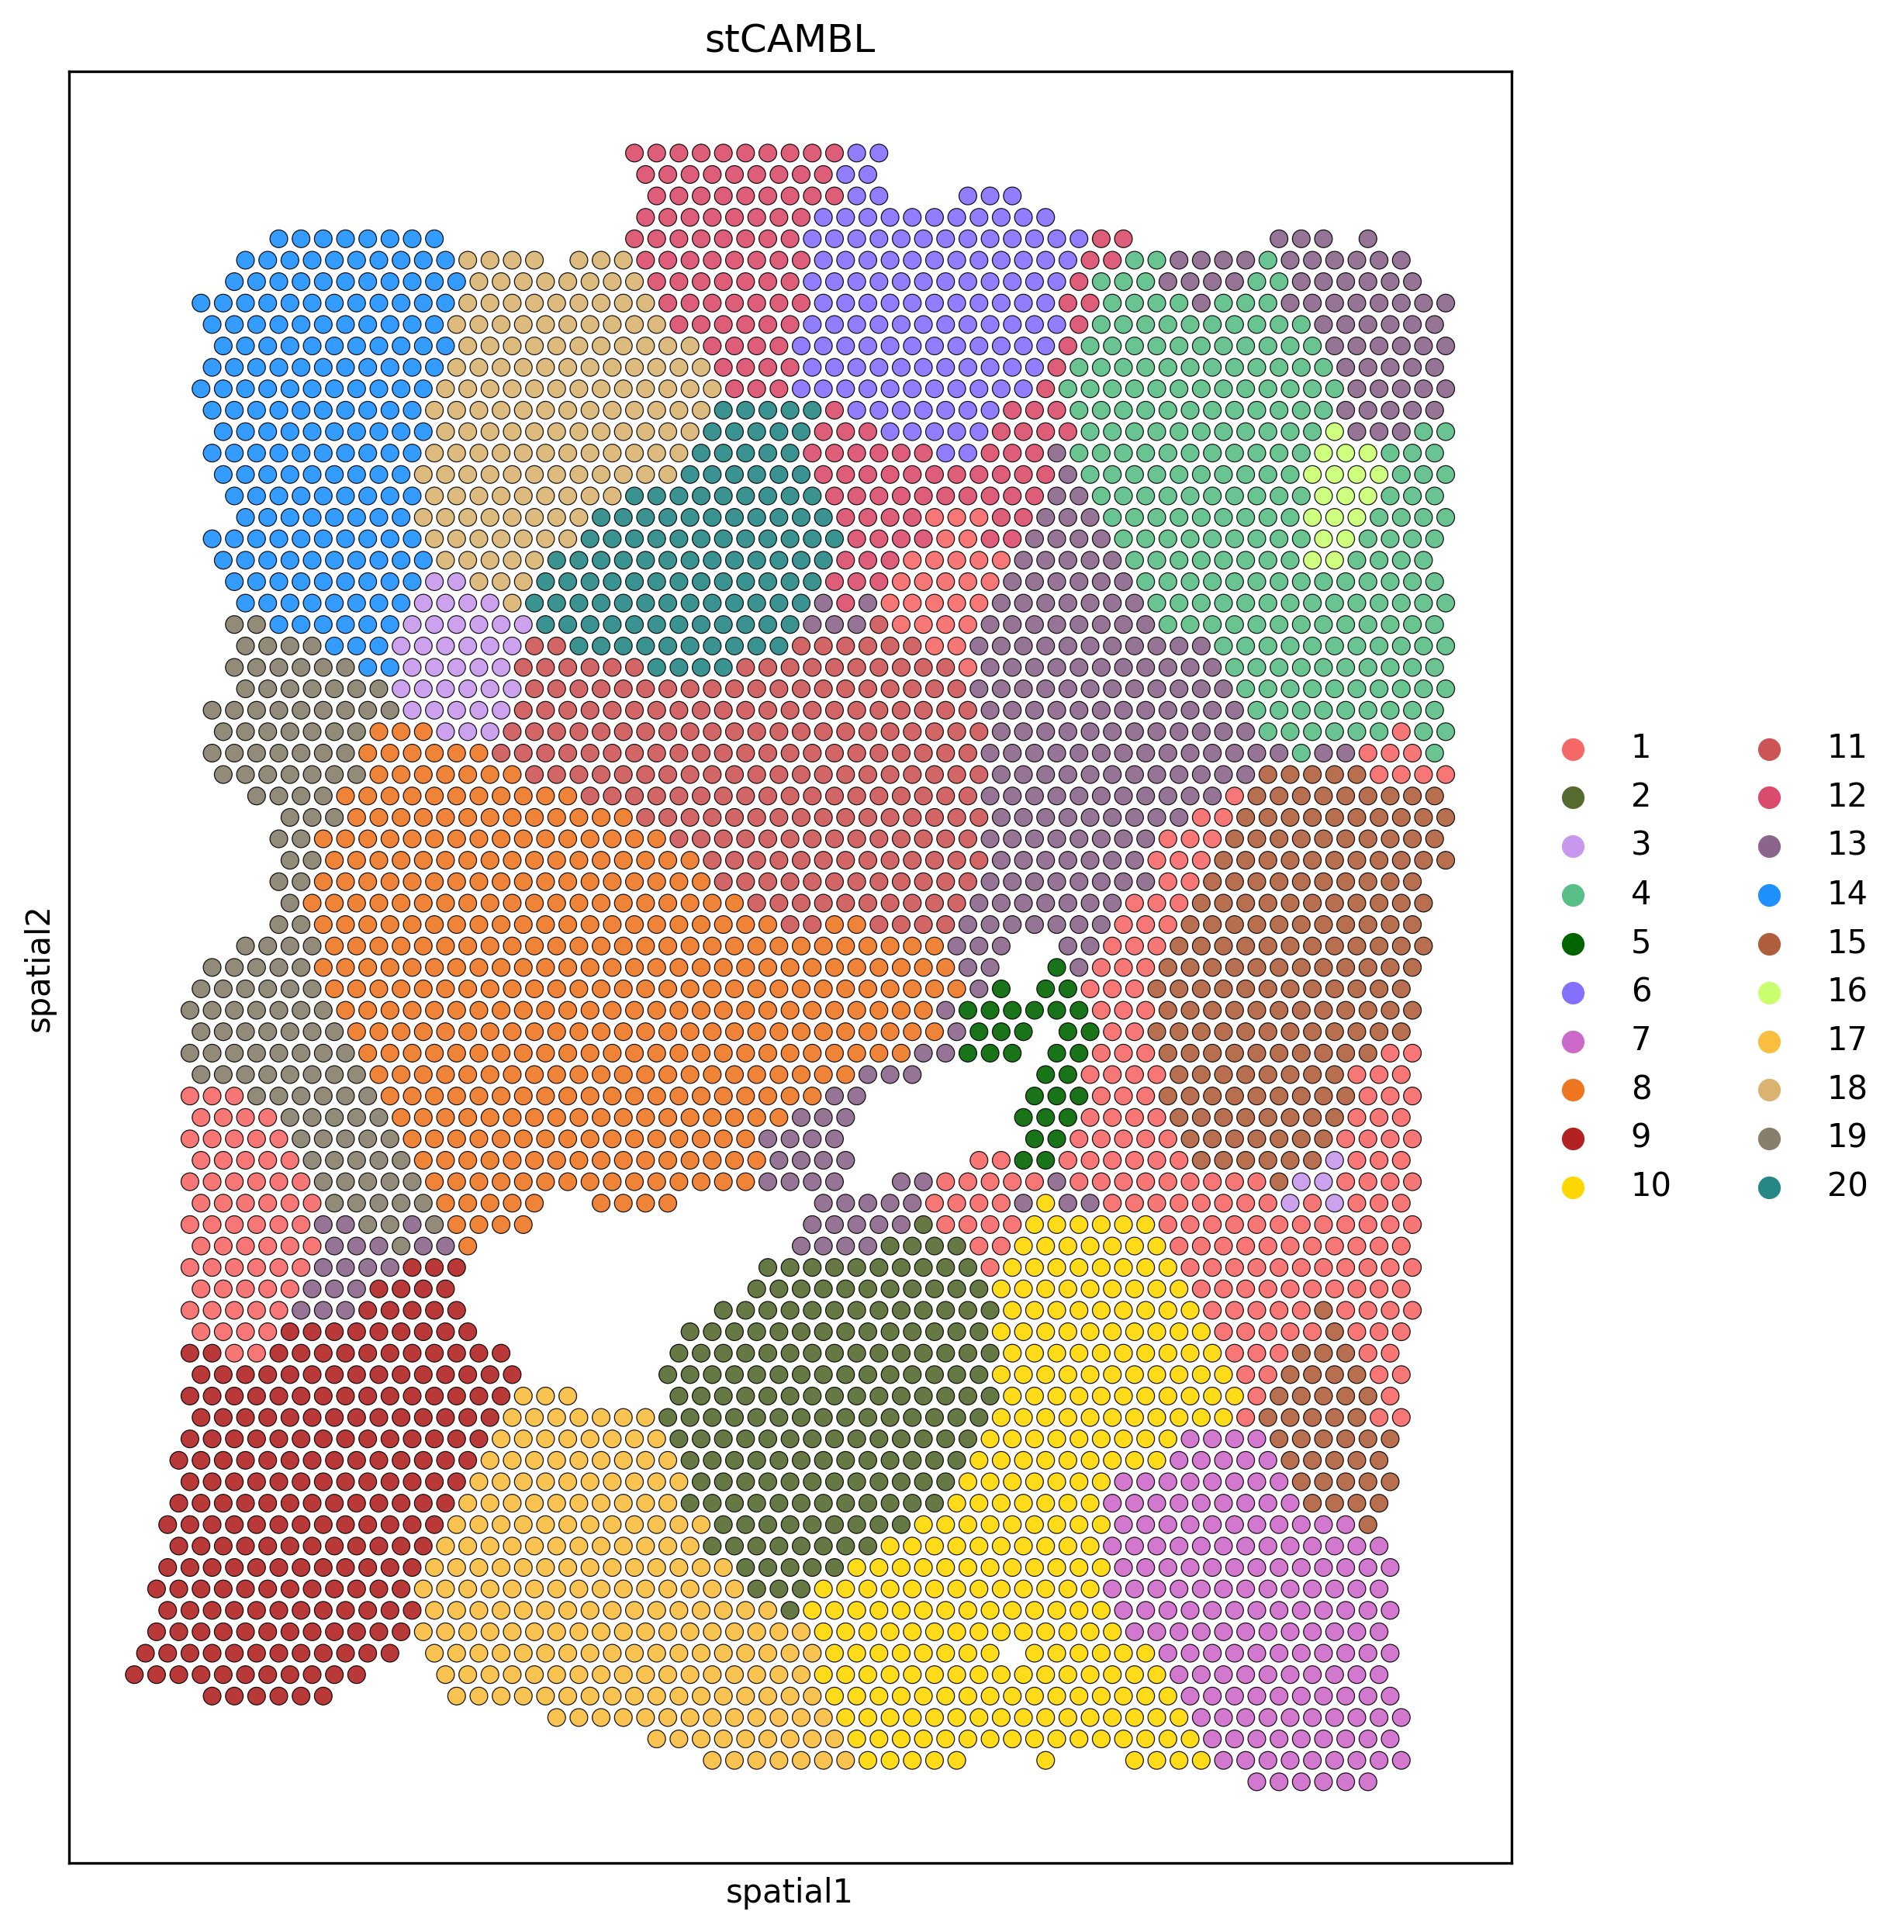

In [7]:
plot_color=["#F56867","#556B2F","#C798EE","#59BE86","#006400","#8470FF",
           "#CD69C9","#EE7621","#B22222","#FFD700","#CD5555","#DB4C6C",
           "#8B658B","#1E90FF","#AF5F3C","#CAFF70", "#F9BD3F","#DAB370",
          "#877F6C","#268785", '#82EF2D', '#B4EEB4']

radius = 50
tool = 'mclust' 
from stCAMBL.clust_func import clustering
clustering(adata, n_clusters=20, radius=radius, method=tool, refinement=True)

adata.obsm['spatial'][:, 1] = -1*adata.obsm['spatial'][:, 1]

# Set figure parameters
plt.rcParams["figure.figsize"] = (8, 10)  
plt.rcParams['figure.dpi'] = 300 
plt.rcParams['savefig.dpi'] = 300  
plt.rcParams['font.family'] = 'DejaVu Sans'  
ax = sc.pl.embedding(adata, basis="spatial",
                    color=['domain'],
                    s=120,  
                    alpha=0.9,
                    edgecolor='black',
                    linewidth=0.3,
                    show=True,
                    palette=plot_color,
                    title='stCAMBL',)
